In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:03<00:00, 2559.40it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

# dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)


In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

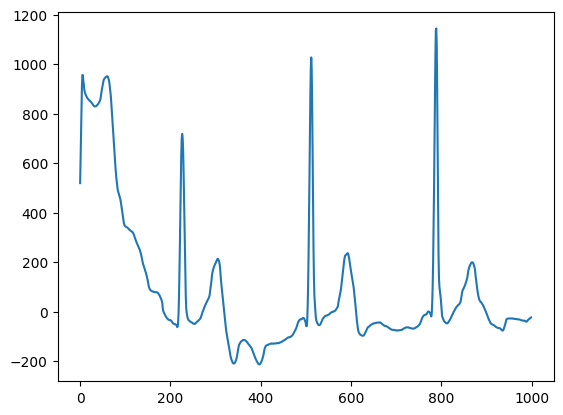

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:0.02418 AVG Test Loss:0.02266 AVG Training Acc 56.72 % AVG Test Acc 59.51 %
Epoch:20/200 AVG Training Loss:0.02248 AVG Test Loss:0.02203 AVG Training Acc 61.89 % AVG Test Acc 62.71 %
Epoch:30/200 AVG Training Loss:0.02148 AVG Test Loss:0.02068 AVG Training Acc 64.38 % AVG Test Acc 65.42 %
Epoch:40/200 AVG Training Loss:0.02102 AVG Test Loss:0.01990 AVG Training Acc 64.61 % AVG Test Acc 67.98 %
Epoch:50/200 AVG Training Loss:0.02018 AVG Test Loss:0.01993 AVG Training Acc 66.62 % AVG Test Acc 68.82 %
Epoch:60/200 AVG Training Loss:0.02054 AVG Test Loss:0.01936 AVG Training Acc 65.29 % AVG Test Acc 69.79 %
Epoch:70/200 AVG Training Loss:0.02012 AVG Test Loss:0.01895 AVG Training Acc 67.38 % AVG Test Acc 68.43 %
Epoch:80/200 AVG Training Loss:0.02013 AVG Test Loss:0.01876 AVG Training Acc 65.06 % AVG Test Acc 69.32 %
Epoch:90/200 AVG Training Loss:0.01982 AVG Test Loss:0.01871 AVG Training Acc 65.70 % AVG Test Acc 69.35 %
Epoch:100/200 AVG Training Loss:0.019

In [13]:
len(dataset_12lead)/20

165.9

In [14]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

# history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

# plot_tt_graph(history, idx=0)
# display_results(history, trainparams=trainparams)

In [15]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

# history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, test=False)

# plot_tt_graph(history, idx=0)
# display_results(history, trainparams=trainparams)

In [16]:
transfer_def = TransferDef()
transfer_def.return_request = [4]

from torch.utils.tensorboard import SummaryWriter

model = TransferModel(buffer, transfer_def)

# Initialize the summary writer
writer = SummaryWriter()

# Create dummy input that corresponds to the network's input shape
input_tensor = torch.rand(128, 1000, 12)

# Add the model graph to TensorBoard
writer.add_graph(model, input_tensor)
writer.close()


# test_forwards(model, data_12lead, labelmap, device)

NameError: name 'TransferDef' is not defined

In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)